<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


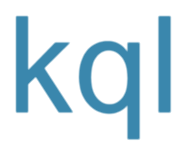

In [1]:
%reload_ext Kqlmagic
%config Kqlmagic.display_limit = 5 #limiting the number of rows displayed (full rows will still be stored)

In [32]:
LOG_ANALYTICS_WORKSPACE_ID = "ea9e6054-b7da-4e19-aa64-a2dd8fb8d7a8" 
ALIAS = 'flpydde' # add your alias. Can be anything, but should not be empty
%kql loganalytics://code;workspace=LOG_ANALYTICS_WORKSPACE_ID;alias=ALIAS

In [3]:
import numpy as np

In [78]:
brain_name = "house-energy-opt-main".lower()
assessment_name = "target_assessment".lower()
list_brain_version = [25,36,34,43,37,42, 44]

In [69]:
import pandas as pd
def format_kql_logs(df: pd.DataFrame) -> pd.DataFrame:
    ''' Function to format a dataframe obtained from KQL query.
        Output format: keeps only selected columns, and flatten nested columns [SimAction, SimState, SimConfig]

        Parameters
        ----------
        df : DataFrame
            dataframe obtained from running KQL query then exporting `_kql_raw_result_.to_dataframe()`
    '''
    selected_columns = ["Timestamp", "IterationIndex", "Reward", "CumulativeReward", "Terminal", "SimState", "SimAction", "SimConfig", "EpisodeId"]
    nested_columns =  [ "SimState", "SimAction", "SimConfig"]
    df_selected_columns = df[selected_columns]
    series_lst = []
    ordered_columns = ["EpisodeId", "IterationIndex", "Reward", "Terminal"]
    for i in nested_columns:
        new_series = df_selected_columns[i].apply(pd.Series)
        column_names = new_series.columns.values.tolist()
        series_lst.append(new_series)
        if len(column_names) > 0:
            ordered_columns.extend(column_names)
        del(df_selected_columns[i])

    series_lst.append(df_selected_columns)
    formated_df = pd.concat(series_lst, axis=1)
    formated_df = formated_df.sort_values(by='Timestamp',ascending=True) # reorder df based on Timestamp
    formated_df.index = range(len(formated_df)) # re-index
    formated_df['Timestamp']=pd.to_datetime(formated_df['Timestamp']) # convert Timestamp to datetime

    formated_df = formated_df[ordered_columns]
    
    return formated_df.sort_values(by=["EpisodeId", "IterationIndex"])


In [70]:
def get_query(brain_name,assessment_name,brain_version):
    my_query = f"""
    let _brain_name = "{brain_name}";
    let _brain_version = "{brain_version}";
    let _assessment_name = "{assessment_name}";
    EpisodeLog_CL
      | where BrainName_s == _brain_name and BrainVersion_d == _brain_version and AssessmentName_s == _assessment_name
      | join kind=inner (
          IterationLog_CL
          | sort by Timestamp_t desc
      ) on EpisodeId_g
      | project 
          AssessmentName = AssessmentName_s,
          EpisodeId = EpisodeId_g,
          IterationIndex = IterationIndex_d,
          Timestamp = Timestamp_t,
          SimConfig = parse_json(SimConfig_s),
          SimState = parse_json(SimState_s),
          SimAction = parse_json(SimAction_s),
          Reward = Reward_d,
          CumulativeReward = CumulativeReward_d,
          GoalMetrics = parse_json(GoalMetrics_s),
          Terminal = Terminal_b,
          FinishReason = FinishReason_s,
          LessonIndex = LessonIndex_d,
          EpisodeType = EpisodeType_s
      | order by EpisodeId asc, IterationIndex asc"""
    return my_query

In [79]:
list_query_results = []
list_flat_data = []
for brain_version in list_brain_version:
    my_query = get_query(brain_name,assessment_name,brain_version)
    log = %kql -query my_query -auto_dataframe true
    list_query_results.append(log)
    list_flat_data.append(format_kql_logs(log))


In [76]:
def compute_kpi(data):
    df_results = data.copy()
    df_results['SE'] = (df_results['Tset'] - df_results['Tin'])**2
    df_agg = df_results.groupby('EpisodeId').agg({'SE': [np.mean]})
    df_agg.columns = ['_'.join(col) for col in df_agg.columns.values]
    df_agg['RMSE'] = df_agg['SE_mean'].apply(np.sqrt)
    df_power_agg = df_results.groupby('EpisodeId').agg({'total_power': [np.max]})
    df_power_agg.columns = ['_'.join(col) for col in df_power_agg.columns.values]
    return df_agg['RMSE'].mean(), df_agg['RMSE'].std(), df_power_agg['total_power_amax'].mean(), df_power_agg['total_power_amax'].std()

In [80]:
final_results = {'Experiment': [], 'RMSE # episodes': [], 'Power Consumption # Episodes': []}

for i, data in enumerate(zip(list_brain_version,list_flat_data)):
    rmse_mean, rmse_std, power_mean, power_std = compute_kpi(data)
    final_results.append((br, rmse_mean, rmse_std, power_mean, power_std))
    print('Brain version:', br)
    print('RSME per Episodes:',f'{rmse_mean} +- {rmse_std}')
    print('Total_power_consumption per Episodes:',f'{power_mean} +- {power_std}')
    final_results['Experiment'].append(i)
    final_results[ 'RMSE # episodes'].append(f'{rmse_mean} +- {rmse_std}')
    final_results['Power Consumption # Episodes'].append(f'{power_mean} +- {power_std}')

AttributeError: 'tuple' object has no attribute 'copy'

In [ ]:
df_final = pd.DataFrame(final_results)

In [ ]:
df_final